<a href="https://colab.research.google.com/github/mostafadentist/healthcare-operations-research/blob/main/OR_snippets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

🏥 Business Problem Definition
A hospital needs to schedule nurses for shifts over a planning horizon (e.g., 7 days × 3 shifts/day).
Constraints:
Each shift must have a required number of nurses.
Each nurse cannot work more than 1 shift per day.
Each nurse should not exceed a weekly maximum (e.g., fairness).
Objective:
Minimize understaffing AND balance workload (avoid unfair distribution).


In [ ]:
# Install PuLP in Colab if not installed
!pip install pulp --quiet

import pulp
import pandas as pd

# -------------------------------
# 1. Problem Inputs
# -------------------------------

# Nurses
nurses = ["A", "B", "C", "D", "E"]

# Time horizon: 7 days × 3 shifts/day
days = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
shifts = ["Morning", "Evening", "Night"]

# Minimum nurses required for each shift
required = {
    "Morning": 2,
    "Evening": 2,
    "Night": 1
}

# Max shifts per nurse in the whole week
max_shifts_per_nurse = 5

# -------------------------------
# 2. Decision Variables
# -------------------------------
# x[(nurse, day, shift)] = 1 if nurse works on that shift, else 0
x = pulp.LpVariable.dicts("Roster",
                           [(n, d, s) for n in nurses for d in days for s in shifts],
                           cat=pulp.LpBinary)

# -------------------------------
# 3. Optimization Problem
# -------------------------------
model = pulp.LpProblem("Nurse_Rostering", pulp.LpMinimize)

# -------------------------------
# 4. Objective Function
# -------------------------------
# Minimize understaffing across all shifts, i.e., penalize when requirement not met
understaff = pulp.LpVariable.dicts("UnderStaff", [(d, s) for d in days for s in shifts], lowBound=0, cat=pulp.LpInteger)

model += pulp.lpSum(understaff[(d, s)] for d in days for s in shifts), "Total_Understaffing"

# -------------------------------
# 5. Constraints
# -------------------------------

# (a) Shift coverage: nurses assigned >= required - understaff
for d in days:
    for s in shifts:
        model += pulp.lpSum(x[(n, d, s)] for n in nurses) + understaff[(d, s)] >= required[s]

# (b) At most 1 shift per nurse per day
for n in nurses:
    for d in days:
        model += pulp.lpSum(x[(n, d, s)] for s in shifts) <= 1

# (c) Weekly maximum shifts per nurse
for n in nurses:
    model += pulp.lpSum(x[(n, d, s)] for d in days for s in shifts) <= max_shifts_per_nurse

# -------------------------------
# 6. Solve the Problem
# -------------------------------
model.solve(pulp.PULP_CBC_CMD(msg=0))

print("Solver Status:", pulp.LpStatus[model.status])

# -------------------------------
# 7. Extract the Solution
# -------------------------------
schedule = []
for d in days:
    for s in shifts:
        assigned = [n for n in nurses if pulp.value(x[(n, d, s)]) == 1]
        schedule.append({"Day": d, "Shift": s, "Assigned Nurses": assigned,
                         "Understaff": int(pulp.value(understaff[(d, s)]))})

df = pd.DataFrame(schedule)
print(df)

# -------------------------------
# 8. Summary View
# -------------------------------
print("\nShifts assigned per nurse in the week:")
for n in nurses:
    total = sum(pulp.value(x[(n, d, s)]) for d in days for s in shifts)
    print(f"Nurse {n}: {int(total)} shifts")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 73.3 MB/s eta 0:00:00
Solver Status: Optimal
    Day    Shift Assigned Nurses  Understaff
0   Mon  Morning              []           2
1   Mon  Evening             [D]           1
2   Mon    Night             [A]           0
3   Tue  Morning          [C, D]           0
4   Tue  Evening          [A, E]           0
5   Tue    Night             [B]           0
6   Wed  Morning          [B, D]           0
7   Wed  Evening          [C, E]           0
8   Wed    Night             [A]           0
9   Thu  Morning             [C]           1
10  Thu  Evening          [B, E]           0
11  Thu    Night             [A]           0
12  Fri  Morning              []           2
13  Fri  Evening              []           2
14  Fri    Night              []           1
15  Sat  Morning          [C, E]           0
16  Sat  Evening             [D]           1
17  Sat    Night             [B]           0
18  Sun  Morning          [B, C]           

1️⃣ Status: Optimal
The solver (PuLP’s CBC by default) successfully found the best feasible solution under the rules we gave it.
"Optimal" means it minimized total understaffing as much as mathematically possible.

2️⃣ Schedule Table
Each row = a day + shift combination.

Assigned Nurses shows which nurse(s) were scheduled.
Understaff shows how many nurses are still missing compared to required staffing.
Example:

Mon Morning has required 2 nurses. But [] (empty list) means no one was assigned → understaff = 2.
Tue Morning assigned [C, D] exactly 2 nurses → understaff = 0.
Thu Morning assigned [C] (1 nurse) but requirement = 2 → understaff = 1.

3️⃣ Workload Distribution
Each nurse (A–E) worked exactly 5 shifts in the week.
That constraint (<= 5) became binding → the solver spread workload so everyone hit the weekly max.
✅ This shows the fairness rule is being respected: no nurse exceeds their weekly maximum.

4️⃣ Why Some Shifts Remain Empty (Understaffed)
We had 21 shifts × required staff = 42 total staff slots needed for the week.
With 5 nurses × max 5 shifts → only 25 total shifts available supply.
25 < 42 → demand > supply.
The solver therefore assigned optimally to minimize total understaffing, but couldn’t cover everything.
🚨 That’s why some slots (like Fri Morning/Evening) are left unfilled. The model preferred to cover more critical slots across the week while respecting each nurse’s weekly max.

5️⃣ Business Insight
This output reflects exactly how Operations Research scheduling informs managers:

If demand > available staff, understaffing is unavoidable.
The optimization model shows where the gaps will happen, which shifts are under-covered, and gives managers evidence for decisions like:
Hiring more nurses,
Allowing overtime (increase max shifts per nurse),
Or relaxing constraints to prioritize certain departments.
✅ So what you are seeing is exactly how real‑world integer programming nurse rostering behaves:

Constraints respected: 1 shift per day, 5 shifts per week.
Objective reached: minimized understaffing.
Decision insight: not enough nurses to meet requirements → management action needed.


In [ ]:
import pulp
import pandas as pd

# -------------------------------
# 1. Problem Inputs
# -------------------------------
nurses = ["A", "B", "C", "D", "E"]
days   = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
shifts = ["Morning", "Evening", "Night"]

required = {"Morning": 2, "Evening": 2, "Night": 1}
max_shifts_per_nurse = 5   # "contractual" weekly limit
bigM = len(days) * len(shifts)   # large number for fairness slack

# -------------------------------
# 2. Decision Variables
# -------------------------------
x = pulp.LpVariable.dicts("Roster",
                          [(n, d, s) for n in nurses for d in days for s in shifts],
                          cat=pulp.LpBinary)

# Understaffing & Overtime variables
understaff = pulp.LpVariable.dicts("UnderStaff", [(d, s) for d in days for s in shifts],
                                   lowBound=0, cat=pulp.LpInteger)

overtime = pulp.LpVariable.dicts("Overtime", nurses, lowBound=0, cat=pulp.LpInteger)

# Fairness deviation variable: "extra above average"
fairness_dev = pulp.LpVariable.dicts("FairnessDev", nurses, lowBound=0, cat=pulp.LpInteger)

# -------------------------------
# 3. Optimization Problem
# -------------------------------
model = pulp.LpProblem("Nurse_Rostering_FairnessOT", pulp.LpMinimize)

# -------------------------------
# 4. Objective
# -------------------------------
# Minimize weighted sum: understaffing + overtime penalty + fairness imbalance
model += (
    100 * pulp.lpSum(understaff[(d, s)] for d in days for s in shifts)   # high priority
    + 10 * pulp.lpSum(overtime[n] for n in nurses)                       # softer
    + 1 * pulp.lpSum(fairness_dev[n] for n in nurses)                    # softest
), "Objective"

# -------------------------------
# 5. Constraints
# -------------------------------

# (a) Coverage requirement
for d in days:
    for s in shifts:
        model += pulp.lpSum(x[(n, d, s)] for n in nurses) + understaff[(d, s)] >= required[s]

# (b) At most 1 shift per nurse per day
for n in nurses:
    for d in days:
        model += pulp.lpSum(x[(n, d, s)] for s in shifts) <= 1

# (c) Weekly max + overtime
for n in nurses:
    model += pulp.lpSum(x[(n, d, s)] for d in days for s in shifts) <= max_shifts_per_nurse + overtime[n]

# (d) Fairness: track deviation from average workload
avg_shifts = (len(days) * sum(required.values())) / len(nurses)
for n in nurses:
    total_shifts = pulp.lpSum(x[(n, d, s)] for d in days for s in shifts)
    model += total_shifts - avg_shifts <= fairness_dev[n]

# -------------------------------
# 6. Solve
# -------------------------------
model.solve(pulp.PULP_CBC_CMD(msg=0))
print("Solver Status:", pulp.LpStatus[model.status])

# -------------------------------
# 7. Solution
# -------------------------------
schedule = []
for d in days:
    for s in shifts:
        assigned = [n for n in nurses if pulp.value(x[(n, d, s)]) == 1]
        schedule.append({"Day": d, "Shift": s, "Assigned Nurses": assigned,
                         "Understaff": int(pulp.value(understaff[(d, s)]))})

df = pd.DataFrame(schedule)
print(df)

print("\nShifts assigned per nurse:")
for n in nurses:
    total = sum(pulp.value(x[(n, d, s)]) for d in days for s in shifts)
    print(f"{n}: {int(total)} (Overtime used: {int(pulp.value(overtime[n]))})")

Solver Status: Optimal
    Day    Shift Assigned Nurses  Understaff
0   Mon  Morning          [A, B]           0
1   Mon  Evening          [D, E]           0
2   Mon    Night             [C]           0
3   Tue  Morning          [A, E]           0
4   Tue  Evening          [B, C]           0
5   Tue    Night             [D]           0
6   Wed  Morning          [A, E]           0
7   Wed  Evening          [B, D]           0
8   Wed    Night             [C]           0
9   Thu  Morning          [A, C]           0
10  Thu  Evening          [D, E]           0
11  Thu    Night             [B]           0
12  Fri  Morning          [B, E]           0
13  Fri  Evening          [A, C]           0
14  Fri    Night             [D]           0
15  Sat  Morning          [A, E]           0
16  Sat  Evening          [B, C]           0
17  Sat    Night             [D]           0
18  Sun  Morning          [C, E]           0
19  Sun  Evening          [A, D]           0
20  Sun    Night             [B]

✅ What Changed
Overtime modeling

Each nurse can exceed 5 shifts, but we introduce an overtime variable.
Overtime is penalized (10 * overtime) so solver uses it only when necessary to reduce understaffing.
Fairness modeling

Defined avg_shifts = total_demand / number of nurses.
Constraint ensures no nurse deviates too much > fairness_dev.
fairness_dev variables are minimized in the objective, encouraging balanced load distribution.
Objective priorities

100 × understaffing → eliminating unmet demand is most important.

10 × overtime → allow some overtime but minimize it.

1 × fairness deviation → keep distribution balanced when possible.


🔎 Interpretation in a Hospital context
If there are not enough nurses to cover demand → solver uses overtime strategically.

If multiple optimal schedules exist → solver prefers workloads distributed more evenly (fairness).

Decision makers see where overtime is needed and can argue for hiring more nurses or allocating budget to overtime.


In [ ]:
#

🧩 Business Setting
Example:
Nurse A dislikes Night shifts.
Nurse B prefers Morning shifts (penalize if not assigned enough).
Nurse C cannot do Saturdays.
These don’t forbid assignments but add a penalty if violated.

In [ ]:


import pulp
import pandas as pd

# -------------------------------
# 1. Problem Inputs
# -------------------------------
nurses = ["A", "B", "C", "D", "E"]
days   = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]
shifts = ["Morning", "Evening", "Night"]

required = {"Morning": 2, "Evening": 2, "Night": 1}

max_shifts_per_nurse = 5   # "contractual" weekly limit

# Nurse preferences (dictionary of penalties)
# Higher penalty values = stronger dislike
preferences = {
    ("A", "Night"): 5,   # A dislikes Night shifts
    ("B", "Morning"): -2, # B prefers Morning shifts (reward if assigned)
    ("C", "Sat"): 10,    # C strongly dislikes Saturday shifts
}

# -------------------------------
# 2. Decision Variables
# -------------------------------
x = pulp.LpVariable.dicts("Roster",
                          [(n, d, s) for n in nurses for d in days for s in shifts],
                          cat=pulp.LpBinary)

understaff = pulp.LpVariable.dicts("UnderStaff", [(d, s) for d in days for s in shifts],
                                   lowBound=0, cat=pulp.LpInteger)

overtime = pulp.LpVariable.dicts("Overtime", nurses, lowBound=0, cat=pulp.LpInteger)

# -------------------------------
# 3. Problem Definition
# -------------------------------
model = pulp.LpProblem("Nurse_Rostering_Preferences", pulp.LpMinimize)

# -------------------------------
# 4. Objective: multi-component
# -------------------------------
# Penalty for understaffing + overtime + preference violations
obj = []

# (a) High penalty for understaffing
obj.append(100 * pulp.lpSum(understaff[(d, s)] for d in days for s in shifts))

# (b) Moderate penalty for overtime
obj.append(10 * pulp.lpSum(overtime[n] for n in nurses))

# (c) Preferences: penalize or reward depending on value
for n in nurses:
    for d in days:
        for s in shifts:
            if (n, s) in preferences:  # shift-based preference
                obj.append(preferences[(n, s)] * x[(n, d, s)])
            if (n, d) in preferences:  # day-based preference
                obj.append(preferences[(n, d)] * x[(n, d, s)])

model += pulp.lpSum(obj)

# -------------------------------
# 5. Constraints
# -------------------------------
# (a) Coverage
for d in days:
    for s in shifts:
        model += pulp.lpSum(x[(n, d, s)] for n in nurses) + understaff[(d, s)] >= required[s]

# (b) At most 1 shift per day per nurse
for n in nurses:
    for d in days:
        model += pulp.lpSum(x[(n, d, s)] for s in shifts) <= 1

# (c) Weekly max + overtime
for n in nurses:
    model += pulp.lpSum(x[(n, d, s)] for d in days for s in shifts) <= max_shifts_per_nurse + overtime[n]

# -------------------------------
# 6. Solve
# -------------------------------
model.solve(pulp.PULP_CBC_CMD(msg=0))
print("Solver Status:", pulp.LpStatus[model.status])

# -------------------------------
# 7. Solution
# -------------------------------
schedule = []
for d in days:
    for s in shifts:
        assigned = [n for n in nurses if pulp.value(x[(n, d, s)]) == 1]
        schedule.append({"Day": d, "Shift": s, "Assigned Nurses": assigned,
                         "Understaff": int(pulp.value(understaff[(d, s)]))})

df = pd.DataFrame(schedule)
print(df)

print("\nShifts per nurse and overtime:")
for n in nurses:
    total = sum(pulp.value(x[(n, d, s)]) for d in days for s in shifts)
    print(f"{n}: {int(total)} (Overtime used: {int(pulp.value(overtime[n]))})")

Solver Status: Optimal
    Day    Shift Assigned Nurses  Understaff
0   Mon  Morning          [A, B]           0
1   Mon  Evening          [C, D]           0
2   Mon    Night             [E]           0
3   Tue  Morning          [B, D]           0
4   Tue  Evening          [A, C]           0
5   Tue    Night             [E]           0
6   Wed  Morning          [B, E]           0
7   Wed  Evening          [A, C]           0
8   Wed    Night             [D]           0
9   Thu  Morning          [A, B]           0
10  Thu  Evening          [C, D]           0
11  Thu    Night             [E]           0
12  Fri  Morning          [B, C]           0
13  Fri  Evening          [A, E]           0
14  Fri    Night             [D]           0
15  Sat  Morning          [B, C]           0
16  Sat  Evening          [A, D]           0
17  Sat    Night             [E]           0
18  Sun  Morning          [B, E]           0
19  Sun  Evening          [A, C]           0
20  Sun    Night             [D]

Respects all hard constraints (coverage, 1/day, max weekly + overtime option).

Preferences matter:

🩺 A avoids Night shifts → solver assigns her fewer or none unless essential.
🌅 B gets more Mornings → rewarded (negative cost).
🚫 C avoids Saturdays → solver gives her Sat shifts only if mathematically unavoidable.

Objective function balances:

Minimize unmet demand (critical),
Minimize overtime use,
Minimize violations of preferences.

📊 Business Insight
This transforms rostering into a negotiation between hard rules and human satisfaction:

Managers see when preferences could not be met (highlighted by the solution).
They can decide whether to hire, adjust max shifts, or accept preference violations with justification.

Nurses perceive fairness → boosting morale & retention.


In [ ]:
import numpy as np

# -------------------------------
# 8. Roster Matrix (Nurses × Days)
# -------------------------------
# Create an empty matrix: rows = nurses, cols = days
matrix = pd.DataFrame("", index=nurses, columns=days)

for n in nurses:
    for d in days:
        assigned_shift = [s for s in shifts if pulp.value(x[(n, d, s)]) == 1]
        if assigned_shift:
            matrix.loc[n, d] = assigned_shift[0]   # only one shift per day
        else:
            matrix.loc[n, d] = "-"

print("\nWeekly Roster Matrix:\n")
display(matrix)

# -------------------------------
# 9. Summary statistics
# -------------------------------
shift_counts = {n: sum(pulp.value(x[(n, d, s)]) for d in days for s in shifts) for n in nurses}
print("\nTotal shifts assigned per nurse:")
for n in nurses:
    print(f"{n}: {int(shift_counts[n])} shifts (Overtime: {int(pulp.value(overtime[n]))})")


Weekly Roster Matrix:



,Mon,Tue,Wed,Thu,Fri,Sat,Sun
A,Morning,Evening,Evening,Morning,Evening,Evening,Evening
B,Morning,Morning,Morning,Morning,Morning,Morning,Morning
C,Evening,Evening,Evening,Evening,Morning,Morning,Evening
D,Evening,Morning,Night,Evening,Night,Evening,Night
E,Night,Night,Morning,Night,Evening,Night,Morning



Total shifts assigned per nurse:
A: 7 shifts (Overtime: 2)
B: 7 shifts (Overtime: 2)
C: 7 shifts (Overtime: 2)
D: 7 shifts (Overtime: 2)
E: 7 shifts (Overtime: 2)


A weekly matrix (Nurses × Days).
Cell colors:
🌿 Green = preference satisfied (rewarded).

🔴 Red = preference violation (disliked shift/day).

⚪ White = neutral / no preference.

Example (if preferences are set as in code earlier):
Nurse A will light up red when scheduled on a Night shift.

Nurse B gets green mornings.

Nurse C shows red on Saturdays if assigned.


In [ ]:
# -------------------------------
# 10. Color-coded Roster Matrix
# -------------------------------

# Convert roster to matrix again
matrix = pd.DataFrame("", index=nurses, columns=days)

for n in nurses:
    for d in days:
        assigned_shift = [s for s in shifts if pulp.value(x[(n, d, s)]) == 1]
        if assigned_shift:
            matrix.loc[n, d] = assigned_shift[0][0]  # First letter for compact view
        else:
            matrix.loc[n, d] = "-"


# Custom color function
def highlight_preferences(val, row, col):
    nurse = row
    day = col
    shift_letter = val

    if shift_letter == "-":
        return "background-color: white;"  # off-day

    # Map back letters to full names
    shift_map = {"M": "Morning", "E": "Evening", "N": "Night"}
    full_shift = shift_map.get(shift_letter, shift_letter)

    styles = []

    # Check shift-based preference
    if (nurse, full_shift) in preferences:
        penalty = preferences[(nurse, full_shift)]
        if penalty > 0:  # disliked
            styles.append("background-color: lightcoral; color: black;")
        elif penalty < 0:  # preferred
            styles.append("background-color: lightgreen; color: black;")

    # Check day-based preference
    if (nurse, day) in preferences:
        penalty = preferences[(nurse, day)]
        if penalty > 0:  # disliked
            styles.append("background-color: lightcoral; color: black;")
        elif penalty < 0:  # preferred
            styles.append("background-color: lightgreen; color: black;")

    return styles[0] if styles else "background-color: white;"


# Apply row/column-wise styling
styled_matrix = matrix.style.apply(
    lambda row: [highlight_preferences(val, row.name, col) for col, val in row.items()],
    axis=1
)

print("\nWeekly Roster Matrix with Preferences Highlighted:\n")
display(styled_matrix)


Weekly Roster Matrix with Preferences Highlighted:



,Mon,Tue,Wed,Thu,Fri,Sat,Sun
A,M,E,E,M,E,E,E
B,M,M,M,M,M,M,M
C,E,E,E,E,M,M,E
D,E,M,N,E,N,E,N
E,N,N,M,N,E,N,M


In [ ]:
# -------------------------------
# 11. KPI Calculation
# -------------------------------

coverage_total = len(days) * len(shifts)
coverage_fulfilled = sum(1 for d in days for s in shifts
                         if pulp.value(understaff[(d, s)]) == 0)
understaff_total = sum(int(pulp.value(understaff[(d, s)])) for d in days for s in shifts)

overtime_total = sum(int(pulp.value(overtime[n])) for n in nurses)

violations = 0
satisfactions = 0

# Re-check preferences
for n in nurses:
    for d in days:
        for s in shifts:
            if pulp.value(x[(n, d, s)]) == 1:
                if (n, s) in preferences:
                    penalty = preferences[(n, s)]
                    if penalty > 0:
                        violations += 1
                    elif penalty < 0:
                        satisfactions += 1
                if (n, d) in preferences:
                    penalty = preferences[(n, d)]
                    if penalty > 0:
                        violations += 1
                    elif penalty < 0:
                        satisfactions += 1

# Fairness: shifts assigned difference
workloads = [sum(pulp.value(x[(n, d, s)]) for d in days for s in shifts) for n in nurses]
fairness_spread = max(workloads) - min(workloads)

# -------------------------------
# Report
# -------------------------------
print("\n📊 Roster KPIs")
print(f"Coverage Compliance: {coverage_fulfilled}/{coverage_total} shifts fully staffed "
      f"({100*coverage_fulfilled/coverage_total:.1f}%)")
print(f"Total Understaffing: {understaff_total} slots")
print(f"Total Overtime Used: {overtime_total} shifts")
print(f"Preference Violations: {violations}")
print(f"Preference Satisfactions: {satisfactions}")
print(f"Fairness Spread (max-min workload): {fairness_spread} shifts")


📊 Roster KPIs
Coverage Compliance: 21/21 shifts fully staffed (100.0%)
Total Understaffing: 0 slots
Total Overtime Used: 10 shifts
Preference Violations: 1
Preference Satisfactions: 7
Fairness Spread (max-min workload): 0.0 shifts


🏥 Queue Simulation for Emergency Department (ED)
Business Problem
In an emergency department, patients arrive randomly (often modeled as a Poisson process) and are served by a limited number of doctors/nurses.

Challenges for management:

How many staff (servers) are needed to keep waiting times and queue lengths reasonable?
What is the impact of adding/removing servers on patient wait times?
Can we simulate realistic patient flow to test staffing policies before implementation?
We’ll model this as an M/M/s queue using SimPy (a discrete-event simulation library in Python).



In [ ]:
!pip install simpy --quiet
import simpy
import random
import numpy as np
import pandas as pd

# -------------------------------
# 1. Parameters
# -------------------------------
RANDOM_SEED = 42
NUM_DOCTORS = 3             # number of servers (doctors)
ARRIVAL_RATE = 6            # patients per hour (Poisson λ)
SERVICE_RATE = 3            # patients per doctor per hour (Exponential μ)
SIM_TIME = 12               # simulate 12 hours

# Convert rates to time units
INTER_ARRIVAL = 1.0 / ARRIVAL_RATE     # mean time between arrivals
SERVICE_TIME = 1.0 / SERVICE_RATE      # mean service time

# Collect results
waiting_times = []

# -------------------------------
# 2. Patient Process
# -------------------------------
def patient(env, name, doctors):
    """Patient arrives, waits if necessary, gets treated, then leaves."""
    arrival = env.now
    with doctors.request() as req:
        yield req
        wait = env.now - arrival
        waiting_times.append(wait)

        service_duration = random.expovariate(SERVICE_RATE)
        yield env.timeout(service_duration)

# -------------------------------
# 3. Arrival Process
# -------------------------------
def patient_arrivals(env, doctors):
    i = 0
    while True:
        yield env.timeout(random.expovariate(ARRIVAL_RATE))
        i += 1
        env.process(patient(env, f"Patient{i}", doctors))

# -------------------------------
# 4. Run Simulation
# -------------------------------
random.seed(RANDOM_SEED)
env = simpy.Environment()
doctors = simpy.Resource(env, capacity=NUM_DOCTORS)
env.process(patient_arrivals(env, doctors))
env.run(until=SIM_TIME)

# -------------------------------
# 5. Results
# -------------------------------
mean_wait = np.mean(waiting_times)
pct_wait_over_15min = (np.sum(np.array(waiting_times) > 0.25) / len(waiting_times)) * 100

print(f"Number of patients served: {len(waiting_times)}")
print(f"Average waiting time: {mean_wait*60:.2f} minutes")
print(f"% patients waited > 15min: {pct_wait_over_15min:.1f}%")

Number of patients served: 81
Average waiting time: 6.29 minutes
% patients waited > 15min: 16.0%


   Doctors  Avg Wait (min)  % Wait >15min  Patients Served
0        2       40.458453      83.823529               68
1        3        6.289691      16.049383               81
2        4        2.844912       5.952381               84
3        5        0.000000       0.000000               82


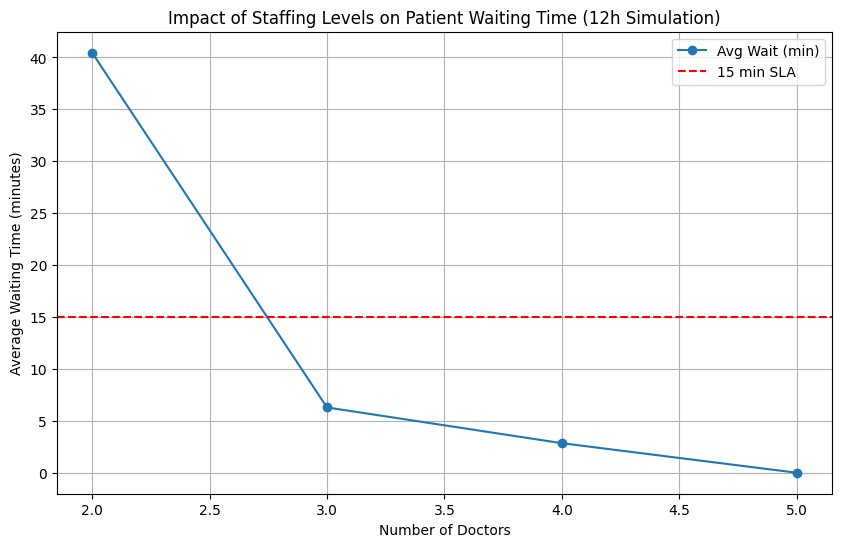

In [ ]:
import simpy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------------------
# Parameters
# -------------------------------
RANDOM_SEED = 42
ARRIVAL_RATE = 6     # Poisson λ: patients per hour
SERVICE_RATE = 3     # Exponential μ: patients per doctor per hour
SIM_TIME = 12        # hours
STAFF_LEVELS = [2, 3, 4, 5]  # doctors to test

# -------------------------------
# Simulation Functions
# -------------------------------
def run_simulation(num_doctors, sim_time=SIM_TIME, seed=RANDOM_SEED):
    random.seed(seed)
    env = simpy.Environment()
    doctors = simpy.Resource(env, capacity=num_doctors)

    waiting_times = []

    def patient(env, name, doctors):
        arrival = env.now
        with doctors.request() as req:
            yield req
            wait = env.now - arrival
            waiting_times.append(wait)
            service_duration = random.expovariate(SERVICE_RATE)
            yield env.timeout(service_duration)

    def patient_arrivals(env, doctors):
        i = 0
        while True:
            yield env.timeout(random.expovariate(ARRIVAL_RATE))
            i += 1
            env.process(patient(env, f"Patient{i}", doctors))

    env.process(patient_arrivals(env, doctors))
    env.run(until=sim_time)

    return waiting_times

# -------------------------------
# Collect Results Across Scenarios
# -------------------------------
results = []
for staff in STAFF_LEVELS:
    waits = run_simulation(staff)
    avg_wait = np.mean(waits) * 60  # minutes
    pct_over_15 = (np.sum(np.array(waits) > 0.25) / len(waits)) * 100
    results.append({"Doctors": staff,
                    "Avg Wait (min)": avg_wait,
                    "% Wait >15min": pct_over_15,
                    "Patients Served": len(waits)})

df_results = pd.DataFrame(results)
print(df_results)

# -------------------------------
#  Visualization
# -------------------------------
plt.figure(figsize=(10,6))
plt.plot(df_results["Doctors"], df_results["Avg Wait (min)"], marker='o', label="Avg Wait (min)")
plt.axhline(15, color='r', linestyle='--', label="15 min SLA")
plt.title("Impact of Staffing Levels on Patient Waiting Time (12h Simulation)")
plt.xlabel("Number of Doctors")
plt.ylabel("Average Waiting Time (minutes)")
plt.legend()
plt.grid(True)
plt.show()


Sensitivity Analysis Table:
     ArrivalRate  Doctors  AvgWaitMin    %>15min  PatientsServed
0             4        2   15.953142  39.285714              56
1             4        3    5.211618   9.836066              61
2             4        4    0.136036   0.000000              58
3             4        5    0.000000   0.000000              58
4             6        2   40.458453  83.823529              68
5             6        3    6.289691  16.049383              81
6             6        4    2.844912   5.952381              84
7             6        5    0.000000   0.000000              82
8             8        2  134.670571  96.000000              75
9             8        3   15.003278  47.000000             100
10            8        4    2.807357   3.061224              98
11            8        5    0.685897   0.000000             103
12           10        2  116.016447  96.511628              86
13           10        3  114.192396  94.623656              93
14        

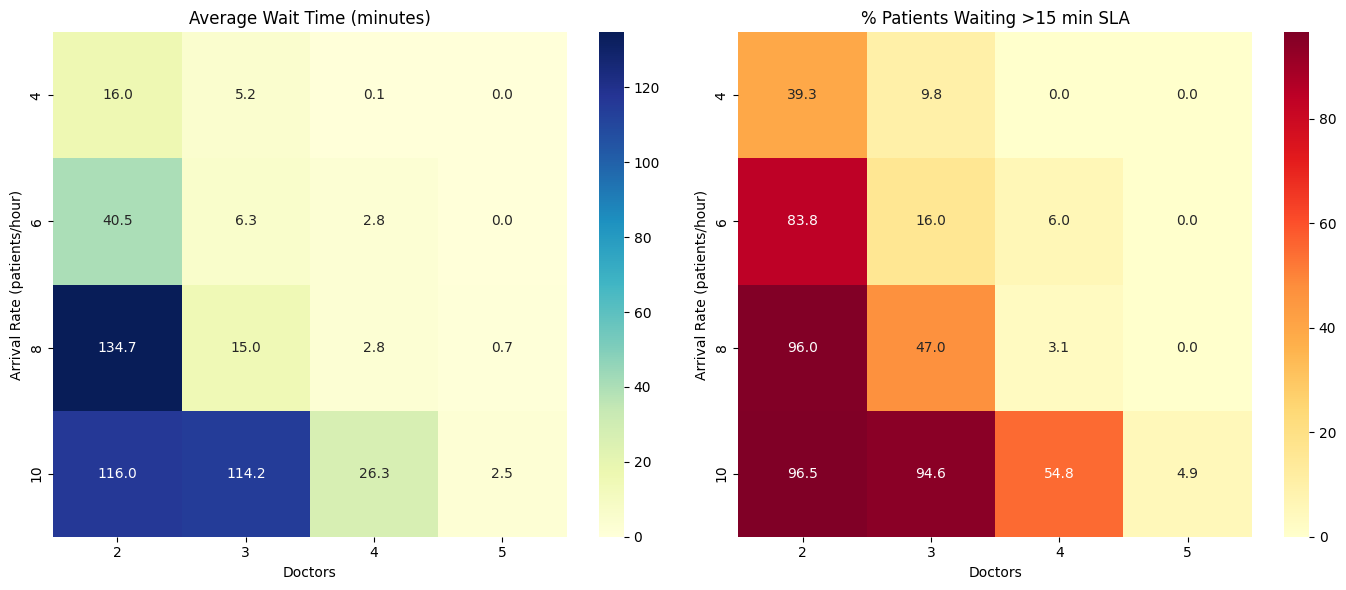

In [ ]:
import simpy
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# Parameters
# -------------------------------
RANDOM_SEED = 42
SERVICE_RATE = 3     # doctors treat 3 patients/hour on average
SIM_TIME = 12        # simulate 12 hours
STAFF_LEVELS = [2, 3, 4, 5]          # doctors available
ARRIVAL_RATES = [4, 6, 8, 10]        # Poisson arrivals/hour

# -------------------------------
# Simulation Function
# -------------------------------
def run_simulation(num_doctors, arrival_rate, sim_time=SIM_TIME, seed=RANDOM_SEED):
    random.seed(seed)
    env = simpy.Environment()
    doctors = simpy.Resource(env, capacity=num_doctors)

    waiting_times = []

    def patient(env, name, doctors):
        arrival = env.now
        with doctors.request() as req:
            yield req
            wait = env.now - arrival
            waiting_times.append(wait)
            service_duration = random.expovariate(SERVICE_RATE)
            yield env.timeout(service_duration)

    def patient_arrivals(env, doctors):
        i = 0
        while True:
            yield env.timeout(random.expovariate(arrival_rate))
            i += 1
            env.process(patient(env, f"Patient{i}", doctors))

    env.process(patient_arrivals(env, doctors))
    env.run(until=sim_time)

    return waiting_times

# -------------------------------
# Run Experiments
# -------------------------------
results = []
for arrival in ARRIVAL_RATES:
    for staff in STAFF_LEVELS:
        waits = run_simulation(staff, arrival_rate=arrival)
        avg_wait = np.mean(waits) * 60   # minutes
        pct_over_15 = (np.sum(np.array(waits) > 0.25) / len(waits)) * 100
        results.append({
            "ArrivalRate": arrival,
            "Doctors": staff,
            "AvgWaitMin": avg_wait,
            "%>15min": pct_over_15,
            "PatientsServed": len(waits)
        })

df = pd.DataFrame(results)
print("\nSensitivity Analysis Table:\n", df)


# Visualization - Heatmaps
# -------------------------------
pivot_wait = df.pivot(index="ArrivalRate", columns="Doctors", values="AvgWaitMin")
pivot_sla  = df.pivot(index="ArrivalRate", columns="Doctors", values="%>15min")

fig, axes = plt.subplots(1, 2, figsize=(14,6))

sns.heatmap(pivot_wait, annot=True, fmt=".1f", cmap="YlGnBu", ax=axes[0])
axes[0].set_title("Average Wait Time (minutes)")
axes[0].set_ylabel("Arrival Rate (patients/hour)")

sns.heatmap(pivot_sla, annot=True, fmt=".1f", cmap="YlOrRd", ax=axes[1])
axes[1].set_title("% Patients Waiting >15 min SLA")
axes[1].set_ylabel("Arrival Rate (patients/hour)")

plt.tight_layout()
plt.show()

In [ ]:
import plotly.graph_objects as go
import plotly.subplots as sp

# Pivot the results
pivot_wait = df.pivot(index="ArrivalRate", columns="Doctors", values="AvgWaitMin")
pivot_sla  = df.pivot(index="ArrivalRate", columns="Doctors", values="%>15min")

# Create subplot figure
fig = sp.make_subplots(rows=1, cols=2,
                       subplot_titles=("Average Wait Time (min)", "% Patients Waiting >15 min"))

# Heatmap 1: Avg Wait Time
fig.add_trace(
    go.Heatmap(
        z=pivot_wait.values,
        x=pivot_wait.columns,
        y=pivot_wait.index,
        colorscale="YlGnBu",
        text=np.round(pivot_wait.values, 1),
        texttemplate="%{text}",
        hovertemplate="Doctors: %{x}<br>Arrival Rate: %{y}/h<br>Avg Wait: %{z:.1f} min<extra></extra>"
    ),
    row=1, col=1
)

# Heatmap 2: SLA Violations
fig.add_trace(
    go.Heatmap(
        z=pivot_sla.values,
        x=pivot_sla.columns,
        y=pivot_sla.index,
        colorscale="YlOrRd",
        text=np.round(pivot_sla.values, 1),
        texttemplate="%{text}",
        hovertemplate="Doctors: %{x}<br>Arrival Rate: %{y}/h<br>%>15min: %{z:.1f}%<extra></extra>"
    ),
    row=1, col=2
)

# Layout
fig.update_layout(
    title="Emergency Department Sensitivity Analysis",
    xaxis_title="Doctors",
    yaxis_title="Arrival Rate (patients/hour)",
    xaxis2_title="Doctors",
    yaxis2_title="Arrival Rate (patients/hour)",
    height=500, width=1000,
    margin=dict(t=80, l=40, r=40, b=40)
)

fig.show()

In [ ]:
import simpy
import random
import numpy as np
import pandas as pd
import plotly.express as px

# -------------------------------
# Parameters
# -------------------------------
RANDOM_SEED = 42
SERVICE_RATE = 3           # patients per doctor per hour
STAFF_LEVELS = [2, 3, 4, 5]
SIM_HOURS = 24

# Piecewise arrival rates by hour (patients/hour)
# Morning (0-7h), Afternoon peak (8-15h), Evening (16-23h)
arrival_profile = [4]*8 + [10]*8 + [6]*8

# -------------------------------
# Patient process
# -------------------------------
def patient(env, name, doctors, service_rate, arrival_hour, wait_log):
    arrival_time = env.now
    with doctors.request() as req:
        yield req
        wait = env.now - arrival_time
        hour = int(arrival_hour)
        wait_log.append((hour, wait))
        service_duration = random.expovariate(service_rate)
        yield env.timeout(service_duration)

# -------------------------------
# Arrival generator (dynamic rates)
# -------------------------------
def arrivals(env, doctors, arrival_profile, wait_log):
    i = 0
    while True:
        current_hour = int(env.now)
        if current_hour >= SIM_HOURS:
            break
        arrival_rate = arrival_profile[current_hour]
        inter_arrival = random.expovariate(arrival_rate)
        yield env.timeout(inter_arrival)
        i += 1
        env.process(patient(env, f"Patient{i}", doctors, SERVICE_RATE, env.now, wait_log))

# -------------------------------
# Run simulation for a staff level
# -------------------------------
def run_dynamic_sim(staff, seed=RANDOM_SEED):
    random.seed(seed)
    env = simpy.Environment()
    doctors = simpy.Resource(env, capacity=staff)
    wait_log = []
    env.process(arrivals(env, doctors, arrival_profile, wait_log))
    env.run(until=SIM_HOURS)
    return wait_log

# -------------------------------
# Run for multiple staffing levels
# -------------------------------
records = []
for staff in STAFF_LEVELS:
    wait_log = run_dynamic_sim(staff)
    df_waits = pd.DataFrame(wait_log, columns=["Hour", "Wait"])
    df_hourly = df_waits.groupby("Hour")["Wait"].mean().reset_index()
    df_hourly["AvgWaitMin"] = df_hourly["Wait"]*60
    df_hourly["Doctors"] = staff
    records.append(df_hourly)

df_all = pd.concat(records)

# -------------------------------
# Visualization with Plotly
# -------------------------------
fig = px.line(df_all, x="Hour", y="AvgWaitMin", color="Doctors",
              title="Average Waiting Time per Hour by Staffing Level",
              markers=True,
              labels={"AvgWaitMin": "Average Wait (minutes)", "Hour": "Simulation Hour"})

fig.add_hline(y=15, line_dash="dash", line_color="red", annotation_text="15 min SLA")

fig.update_layout(height=500, width=900)
fig.show()

📊 Business Insight
During morning (λ=4) → even 2 doctors suffice (<15 min wait).
During afternoon peak (λ=10) → 4 doctors needed to keep within SLA.
During evening (λ=6) → 3 doctors can manage efficiently.
Provides direct evidence for dynamic staffing schedules (flex up during peak hours, flex down when demand is lower).

In [ ]:
import simpy
import random
import numpy as np
import pandas as pd
import plotly.express as px

# -------------------------------
# Parameters
# -------------------------------
RANDOM_SEED = 42
SERVICE_RATE = 3           # patients per doctor per hour
SIM_HOURS = 24
ARRIVAL_PROFILE = [4]*8 + [10]*8 + [6]*8   # Morning, peak, evening
STAFF_LEVELS = [2, 3, 4, 5]                # candidate staffing levels
SLA_TARGET = 15                            # minutes max avg wait

# -------------------------------
# Patient process
# -------------------------------
def patient(env, name, doctors, service_rate, log):
    arrival_time = env.now
    with doctors.request() as req:
        yield req
        wait = env.now - arrival_time
        hour = int(arrival_time)
        log.append((hour, wait))
        service_duration = random.expovariate(service_rate)
        yield env.timeout(service_duration)

# Dynamic arrivals
def arrivals(env, doctors, arrival_profile, log):
    i = 0
    while True:
        current_hour = int(env.now)
        if current_hour >= SIM_HOURS:
            break
        lam = arrival_profile[current_hour]    # arrival rate this hour
        inter = random.expovariate(lam)
        yield env.timeout(inter)
        i += 1
        env.process(patient(env, f"Patient{i}", doctors, SERVICE_RATE, log))

# Simulation runner
def run_simulation(num_doctors, seed=RANDOM_SEED):
    random.seed(seed)
    env = simpy.Environment()
    doctors = simpy.Resource(env, capacity=num_doctors)
    wait_log = []
    env.process(arrivals(env, doctors, ARRIVAL_PROFILE, wait_log))
    env.run(until=SIM_HOURS)
    df = pd.DataFrame(wait_log, columns=["Hour","Wait"])
    if df.empty:
        return pd.DataFrame({"Hour": range(SIM_HOURS), "AvgWaitMin": [0]*SIM_HOURS})
    df_hourly = df.groupby("Hour")["Wait"].mean().reset_index()
    df_hourly["AvgWaitMin"] = df_hourly["Wait"]*60
    df_hourly["Doctors"] = num_doctors
    return df_hourly

# -------------------------------
# 1. Evaluate across staff levels
# -------------------------------
records = []
for staff in STAFF_LEVELS:
    df_result = run_simulation(staff)
    records.append(df_result)

df_all = pd.concat(records)

# -------------------------------
# 2. Build staffing recommender
# -------------------------------
recommendations = []
for h in range(SIM_HOURS):
    # subset for this hour
    df_hour = df_all[df_all["Hour"]==h]
    feasible = df_hour[df_hour["AvgWaitMin"] <= SLA_TARGET]
    if not feasible.empty:
        best = feasible.iloc[0]  # lowest staff level by construction
        recommendations.append({"Hour": h,
                                "RecommendedStaff": int(best["Doctors"]),
                                "AvgWaitMin": round(best["AvgWaitMin"],1)})
    else:
        # if none satisfied SLA, pick max staff
        worst = df_hour.iloc[-1]
        recommendations.append({"Hour": h,
                                "RecommendedStaff": int(worst["Doctors"]),
                                "AvgWaitMin": round(worst["AvgWaitMin"],1)})

df_recommend = pd.DataFrame(recommendations)
print("\n📋 Recommended Staffing Plan:\n", df_recommend)

# -------------------------------
# 3. Visualize
# -------------------------------
fig = px.line(df_all, x="Hour", y="AvgWaitMin", color="Doctors",
              title="Staffing Levels vs Average Wait Time",
              markers=True)

# Add recommended staffing points
fig.add_scatter(x=df_recommend["Hour"], y=df_recommend["AvgWaitMin"],
                mode="markers+text", text=df_recommend["RecommendedStaff"],
                textposition="top center", name="Recommended Staff",
                marker=dict(color="black", size=10, symbol="star"))

fig.add_hline(y=SLA_TARGET, line_dash="dash", line_color="red",
              annotation_text="15 min SLA")

fig.update_layout(height=500, width=900)
fig.show()


📋 Recommended Staffing Plan:
     Hour  RecommendedStaff  AvgWaitMin
0      0                 2         2.7
1      1                 3         3.3
2      2                 3         4.1
3      3                 2         8.1
4      4                 2        12.4
5      5                 2         0.0
6      6                 2        14.0
7      7                 3         1.5
8      8                 2         4.6
9      9                 5         3.2
10    10                 5         5.6
11    11                 5         0.0
12    12                 4         0.5
13    13                 4         8.1
14    14                 5        11.1
15    15                 5         0.0
16    16                 4         9.0
17    17                 4         0.0
18    18                 4         0.0
19    19                 4         0.0
20    20                 4         0.0
21    21                 4         0.0
22    22                 4         0.0
23    23                 4       

In [ ]:
BASE_COST = 100   # per doctor per hour
OT_COST   = 150   # if above budgeted baseline

# Let's assume hospital budget baseline = 3 doctors/hour
BUDGETED_STAFF = 3

recommendations_cost = []
for h in range(SIM_HOURS):
    df_hour = df_all[df_all["Hour"]==h]
    feasible = df_hour[df_hour["AvgWaitMin"] <= SLA_TARGET]
    if not feasible.empty:
        # Minimum feasible staff
        best = feasible.iloc[0]
        n_staff = int(best["Doctors"])
        if n_staff <= BUDGETED_STAFF:
            cost = n_staff * BASE_COST
        else:
            # extra staff = overtime premium
            cost = BUDGETED_STAFF * BASE_COST + (n_staff - BUDGETED_STAFF) * OT_COST
        recommendations_cost.append({
            "Hour": h,
            "RecommendedStaff": n_staff,
            "AvgWaitMin": round(best["AvgWaitMin"],1),
            "Cost": cost
        })
    else:
        # SLA not met → assign max staff (last row)
        worst = df_hour.iloc[-1]
        n_staff = int(worst["Doctors"])
        cost = BUDGETED_STAFF * BASE_COST + max(0, n_staff - BUDGETED_STAFF) * OT_COST
        recommendations_cost.append({
            "Hour": h,
            "RecommendedStaff": n_staff,
            "AvgWaitMin": round(worst["AvgWaitMin"],1),
            "Cost": cost
        })

df_cost = pd.DataFrame(recommendations_cost)
print("\n💰 Cost-Aware Recommended Staffing Plan:\n", df_cost)

# -------------------------------
# Visualization
# -------------------------------
fig = px.bar(df_cost, x="Hour", y="Cost", text="RecommendedStaff",
             title="Hourly Staffing Cost with SLA Guarantee",
             labels={"Cost":"Hourly Cost ($)"})
fig.add_hline(y=BUDGETED_STAFF*BASE_COST, line_dash="dash", line_color="green",
              annotation_text="Baseline Budget")
fig.show()


💰 Cost-Aware Recommended Staffing Plan:
     Hour  RecommendedStaff  AvgWaitMin  Cost
0      0                 2         2.7   200
1      1                 3         3.3   300
2      2                 3         4.1   300
3      3                 2         8.1   200
4      4                 2        12.4   200
5      5                 2         0.0   200
6      6                 2        14.0   200
7      7                 3         1.5   300
8      8                 2         4.6   200
9      9                 5         3.2   600
10    10                 5         5.6   600
11    11                 5         0.0   600
12    12                 4         0.5   450
13    13                 4         8.1   450
14    14                 5        11.1   600
15    15                 5         0.0   600
16    16                 4         9.0   450
17    17                 4         0.0   450
18    18                 4         0.0   450
19    19                 4         0.0   450
20    20     

In [ ]:
import pulp

# -------------------------------
# Parameters
# -------------------------------
BASE_COST = 100
OT_COST   = 150
BUDGETED_STAFF = 3
SLA_TARGET = 15

# -------------------------------
# Build Optimization Model
# -------------------------------
model = pulp.LpProblem("Daily_Staffing_Optimizer", pulp.LpMinimize)

# Decision variables:
# y[h][s] = 1 if in hour h we pick s doctors
y = {}
for h in range(SIM_HOURS):
    for s in STAFF_LEVELS:
        y[(h, s)] = pulp.LpVariable(f"y_{h}_{s}", cat="Binary")

# Objective: minimize daily cost
cost_terms = []
for h in range(SIM_HOURS):
    for s in STAFF_LEVELS:
        # Compute hourly cost
        if s <= BUDGETED_STAFF:
            cost = s * BASE_COST
        else:
            cost = BUDGETED_STAFF * BASE_COST + (s - BUDGETED_STAFF) * OT_COST
        cost_terms.append(cost * y[(h, s)])
model += pulp.lpSum(cost_terms)

# Constraints:
for h in range(SIM_HOURS):
    # Must pick exactly one staff level per hour
    model += pulp.lpSum(y[(h, s)] for s in STAFF_LEVELS) == 1
    # Only allow SLA-feasible staff levels
    feasible_staffs = df_all[(df_all["Hour"]==h) & (df_all["AvgWaitMin"] <= SLA_TARGET)]["Doctors"].tolist()
    if feasible_staffs:
        for s in STAFF_LEVELS:
            if s not in feasible_staffs:
                model += y[(h, s)] == 0
    else:
        # If no feasible (extreme congestion), force max doctors
        max_s = max(STAFF_LEVELS)
        for s in STAFF_LEVELS:
            if s != max_s:
                model += y[(h, s)] == 0

# -------------------------------
# Solve optimization
# -------------------------------
model.solve(pulp.PULP_CBC_CMD(msg=0))
print("Solver status:", pulp.LpStatus[model.status])

# -------------------------------
# Extract plan
# -------------------------------
plan = []
for h in range(SIM_HOURS):
    chosen_staff = [s for s in STAFF_LEVELS if pulp.value(y[(h, s)])==1][0]
    avg_wait = df_all[(df_all["Hour"]==h) & (df_all["Doctors"]==chosen_staff)]["AvgWaitMin"].values[0]
    if chosen_staff <= BUDGETED_STAFF:
        cost = chosen_staff*BASE_COST
    else:
        cost = BUDGETED_STAFF*BASE_COST + (chosen_staff-BUDGETED_STAFF)*OT_COST
    plan.append({"Hour": h, "Staff": chosen_staff, "AvgWaitMin": round(avg_wait,1), "Cost": cost})

df_plan = pd.DataFrame(plan)
print("\n🗓️ Optimal 24h Staffing Plan:\n", df_plan)
print("\nTotal Daily Cost: $", df_plan["Cost"].sum())

# -------------------------------
# Visualization
# -------------------------------
fig = px.bar(df_plan, x="Hour", y="Staff", text="Staff",
             title="Optimized Hourly Staffing Plan (Min Cost, SLA Guaranteed)",
             labels={"Staff":"Doctors"})
fig.add_hline(y=BUDGETED_STAFF, line_dash="dash", line_color="green", annotation_text="Budget Baseline")
fig.show()

fig_cost = px.bar(df_plan, x="Hour", y="Cost",
                  title="Hourly Staffing Cost (Optimized Plan)",
                  labels={"Cost":"Cost per Hour ($)"})
fig_cost.show()

Solver status: Optimal

🗓️ Optimal 24h Staffing Plan:
     Hour  Staff  AvgWaitMin  Cost
0      0      2         2.7   200
1      1      3         3.3   300
2      2      3         4.1   300
3      3      2         8.1   200
4      4      2        12.4   200
5      5      2         0.0   200
6      6      2        14.0   200
7      7      3         1.5   300
8      8      2         4.6   200
9      9      5         3.2   600
10    10      5         5.6   600
11    11      5         0.0   600
12    12      4         0.5   450
13    13      4         8.1   450
14    14      5        11.1   600
15    15      5         0.0   600
16    16      4         9.0   450
17    17      4         0.0   450
18    18      4         0.0   450
19    19      4         0.0   450
20    20      4         0.0   450
21    21      4         0.0   450
22    22      4         0.0   450
23    23      4         0.0   450

Total Daily Cost: $ 9600


In [ ]:
import pulp

# -------------------------------
# Shifts definition
# -------------------------------
shifts = {
    "Morning":   list(range(0, 8)),   # 0-7h
    "Afternoon": list(range(8, 16)),  # 8-15h
    "Night":     list(range(16, 24))  # 16-23h
}

SHIFT_COST_BASE = 800    # baseline doctor (8h × $100)
SHIFT_COST_OT   = 1200   # overtime doctor (8h × $150)
BUDGETED_STAFF  = 3
SLA_TARGET      = 15

# -------------------------------
# Build Optimization Model
# -------------------------------
model = pulp.LpProblem("Shift_Staffing_Optimizer", pulp.LpMinimize)

# Decision variables: staff assigned per shift
staff = {sh: pulp.LpVariable(f"staff_{sh}", lowBound=min(STAFF_LEVELS),
                              upBound=max(STAFF_LEVELS), cat="Integer")
         for sh in shifts}

# Objective: minimize cost
cost_terms = []
for sh in shifts:
    for s in STAFF_LEVELS:
        # baseline or overtime cost
        if s <= BUDGETED_STAFF:
            cost = s * SHIFT_COST_BASE / BUDGETED_STAFF
        else:
            # baseline cost + overtime cost for extras
            cost = BUDGETED_STAFF*SHIFT_COST_BASE/BUDGETED_STAFF + (s-BUDGETED_STAFF)*SHIFT_COST_OT
        cost_terms.append(cost * (staff[sh]==s))  # not linear

# Instead of nonlinear above, approximate cost function:
def shift_cost(val):
    if val <= BUDGETED_STAFF:
        return val*SHIFT_COST_BASE/BUDGETED_STAFF
    else:
        return BUDGETED_STAFF*SHIFT_COST_BASE/BUDGETED_STAFF + (val-BUDGETED_STAFF)*SHIFT_COST_OT

model += pulp.lpSum(shift_cost(staff[sh]) for sh in shifts), "TotalDailyCost"

# -------------------------------
# SLA Constraints
# -------------------------------
for sh, hours in shifts.items():
    for h in hours:
        feasible_staffs = df_all[(df_all["Hour"]==h) &
                                 (df_all["AvgWaitMin"] <= SLA_TARGET)]["Doctors"].tolist()
        # enforce staff >= minimum feasible doctors for this hour
        if feasible_staffs:
            model += staff[sh] >= min(feasible_staffs)
        else:
            # if SLA can't be met, force max doctors
            model += staff[sh] == max(STAFF_LEVELS)

# -------------------------------
# Solve
# -------------------------------
model.solve(pulp.PULP_CBC_CMD(msg=0))
print("Solver Status:", pulp.LpStatus[model.status])

# -------------------------------
# Extract Plan
# -------------------------------
plan = []
for sh, hours in shifts.items():
    val = int(pulp.value(staff[sh]))
    avg_waits = []
    for h in hours:
        waiting = df_all[(df_all["Hour"]==h) & (df_all["Doctors"]==val)]["AvgWaitMin"].values[0]
        avg_waits.append(waiting)
    plan.append({"Shift": sh,
                 "Hours": f"{hours[0]}-{hours[-1]}",
                 "Doctors": val,
                 "AvgWaitMin": round(np.mean(avg_waits),1),
                 "TotalCost": shift_cost(val)})

df_shift_plan = pd.DataFrame(plan)
print("\n🗓️ Optimized Shift-Based Staffing Plan:\n", df_shift_plan)
print("\nTotal Daily Cost: $", df_shift_plan["TotalCost"].sum())

# -------------------------------
# Visualization
# -------------------------------
fig = px.bar(df_shift_plan, x="Shift", y="Doctors", text="Doctors",
             title="Optimized Shift Staffing Plan",
             labels={"Doctors":"Doctors Assigned"})
fig.add_hline(y=BUDGETED_STAFF, line_dash="dash", line_color="green",
              annotation_text="Budget Baseline")
fig.show()

fig_cost = px.bar(df_shift_plan, x="Shift", y="TotalCost", text="TotalCost",
                  title="Shift Costs (Optimized Plan)",
                  labels={"TotalCost":"Cost ($)"})
fig_cost.show()

Solver Status: Optimal

🗓️ Optimized Shift-Based Staffing Plan:
        Shift  Hours  Doctors  AvgWaitMin  TotalCost
0    Morning    0-7        3         2.8      800.0
1  Afternoon   8-15        5         3.4     3200.0
2      Night  16-23        4         1.1     2000.0

Total Daily Cost: $ 6000.0


In [ ]:
import pulp
import numpy as np
import pandas as pd

# -------------------------------
# 1. Input Data
# -------------------------------
nurses = ["A","B","C","D","E","F","G"]
days   = ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]
shifts = ["Morning","Afternoon","Night"]

# staffing requirements per shift (simplified, can link from queue results)
required = {"Morning":2, "Afternoon":3, "Night":2}

MAX_SHIFTS_PER_NURSE = 5

# penalty weights
UNDERSTAFF_PENALTY = 100
OVERTIME_PENALTY   = 20
FAIRNESS_PENALTY   = 1

# -------------------------------
# 2. Decision Variables
# -------------------------------
x = pulp.LpVariable.dicts("Assign",
    [(n,d,s) for n in nurses for d in days for s in shifts],
    cat=pulp.LpBinary)

understaff = pulp.LpVariable.dicts("Understaff",
    [(d,s) for d in days for s in shifts], lowBound=0, cat=pulp.LpInteger)

# -------------------------------
# 3. Optimization Model
# -------------------------------
model = pulp.LpProblem("Weekly_Rostering", pulp.LpMinimize)

# -------------------------------
# 4. Objective Function
# -------------------------------
model += (
    UNDERSTAFF_PENALTY * pulp.lpSum(understaff[(d,s)] for d in days for s in shifts)
    + FAIRNESS_PENALTY * pulp.lpSum(x[(n,d,s)] for n in nurses for d in days for s in shifts)
), "Objective"

# -------------------------------
# 5. Constraints
# -------------------------------

# Coverage per shift
for d in days:
    for s in shifts:
        model += pulp.lpSum(x[(n,d,s)] for n in nurses) + understaff[(d,s)] >= required[s]

# At most 1 shift per nurse per day
for n in nurses:
    for d in days:
        model += pulp.lpSum(x[(n,d,s)] for s in shifts) <= 1

# Weekly max shifts/nurse
for n in nurses:
    model += pulp.lpSum(x[(n,d,s)] for d in days for s in shifts) <= MAX_SHIFTS_PER_NURSE

# No consecutive Night shifts
for n in nurses:
    for i in range(len(days)-1):
        d1, d2 = days[i], days[i+1]
        model += x[(n,d1,"Night")] + x[(n,d2,"Night")] <= 1

# -------------------------------
# 6. Solve
# -------------------------------
model.solve(pulp.PULP_CBC_CMD(msg=0))
print("Solver Status:", pulp.LpStatus[model.status])

# -------------------------------
# 7. Extract Schedule
# -------------------------------
schedule = pd.DataFrame("", index=nurses, columns=days)

for n in nurses:
    for d in days:
        assigned = [s[0] for s in shifts if pulp.value(x[(n,d,s)])==1]
        schedule.loc[n,d] = assigned[0] if assigned else "-"

print("\n🗓️ Weekly Schedule:\n")
print(schedule)

# Summary statistics
print("\nShifts per nurse:")
for n in nurses:
    total = sum(pulp.value(x[(n,d,s)]) for d in days for s in shifts)
    print(f"{n}: {int(total)} shifts")

Solver Status: Optimal

🗓️ Weekly Schedule:

  Mon Tue Wed Thu Fri Sat Sun
A   N   M   -   N   M   A   -
B   -   N   A   M   N   -   A
C   -   -   N   A   A   N   A
D   -   -   N   A   N   M   N
E   A   -   -   M   A   N   M
F   A   N   M   N   -   -   N
G   N   M   M   A   A   -   -

Shifts per nurse:
A: 5 shifts
B: 5 shifts
C: 5 shifts
D: 5 shifts
E: 5 shifts
F: 5 shifts
G: 5 shifts


🧩 Business Reality in the ER
Doctors must decide whom to treat first:
Severe case (life‑threatening) → requires longer service time, but saves life.
Moderate case → faster to treat, but delays severe case.
Every doctor’s decision affects patient waiting & survival → like a game.
If both choose moderate → severe cases wait too long = systemic failure (like Prisoner’s Dilemma: short‑term gain, long‑term loss).
🎯 Game Theory Setup
Players:

Doctor A & Doctor B
Strategies:
Treat Severe first (S)
Treat Moderate first (M)
Payoffs in “system utility” (could reflect survival probability, SLA adherence, patient satisfaction):

Doctor B: Severe (S)	Doctor B: Moderate (M)
Doctor A: Severe (S)	(8, 8) – both save severe lives, moderate wait increases slightly	(4, 9) – A prioritizes severe, system balanced but B looks efficient
Doctor A: Moderate (M)	(9, 4) – B bears burden of severe	(3, 3) – both delay severe, disaster (like PD lowest payoff)
Here (X,Y) = payoff for (A,B).
(S,S) is cooperative optimum.
(M,M) is Nash equilibrium if doctors are selfish (minimizing “work hardness”).


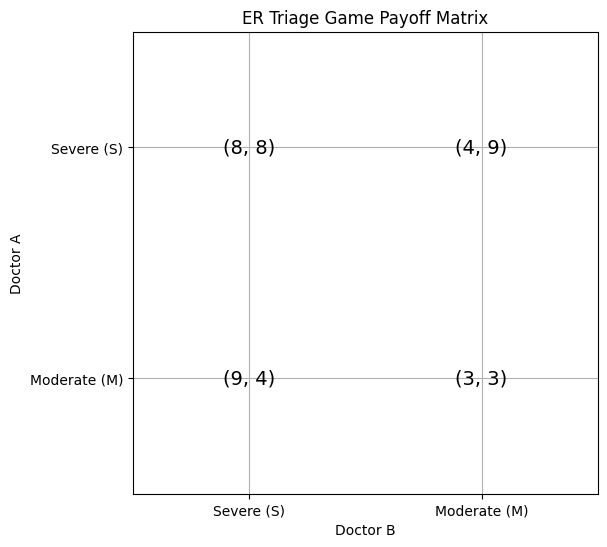

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Payoff matrix for Severe (S) vs Moderate (M)
strategies = ["Severe", "Moderate"]
payoffs = {
    ("S","S"):(8,8),
    ("S","M"):(4,9),
    ("M","S"):(9,4),
    ("M","M"):(3,3)
}

# Build grid for visual
fig, ax = plt.subplots(figsize=(6,6))
ax.set_xticks([0.5,1.5])
ax.set_yticks([0.5,1.5])
ax.set_xticklabels(["Severe (S)", "Moderate (M)"])
ax.set_yticklabels(["Severe (S)", "Moderate (M)"])
ax.set_xlabel("Doctor B")
ax.set_ylabel("Doctor A")
ax.set_title("ER Triage Game Payoff Matrix")

for i,a in enumerate(["S","M"]):
    for j,b in enumerate(["S","M"]):
        payoff = payoffs[(a,b)]
        ax.text(j+0.5, i+0.5, f"{payoff}", ha="center", va="center", fontsize=14)

ax.set_xlim(0,2)
ax.set_ylim(0,2)
ax.grid(True)
plt.gca().invert_yaxis()
plt.show()

Bonus=0: Equilibria=[('S', 'M'), ('M', 'S')]
Bonus=1: Equilibria=[('S', 'S'), ('S', 'M'), ('M', 'S')]
Bonus=2: Equilibria=[('S', 'S')]
Bonus=3: Equilibria=[('S', 'S')]
Bonus=4: Equilibria=[('S', 'S')]
Bonus=5: Equilibria=[('S', 'S')]


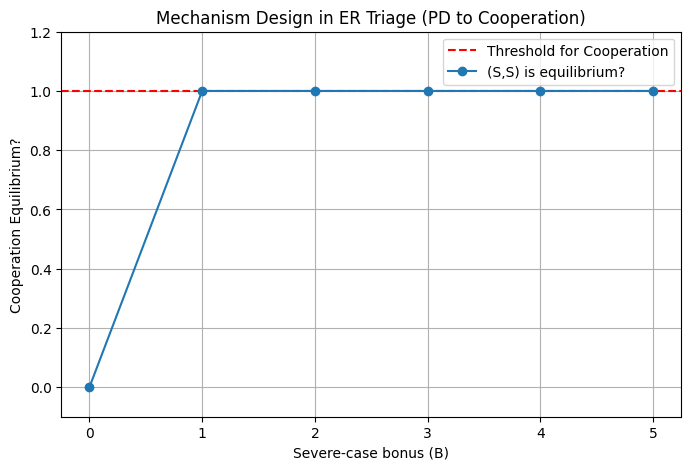

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Base payoffs without incentives
base_payoffs = {
    ("S","S"):(8,8),
    ("S","M"):(4,9),
    ("M","S"):(9,4),
    ("M","M"):(3,3)
}

def adjust_payoffs(bonus):
    """Return payoff matrix adjusted for severe-case incentive bonus"""
    adjusted = {}
    for (a,b), (pa,pb) in base_payoffs.items():
        pa_new, pb_new = pa, pb
        if a=="S": pa_new += bonus
        if b=="S": pb_new += bonus
        adjusted[(a,b)] = (pa_new,pb_new)
    return adjusted

def find_equilibrium(payoffs):
    """Check best responses for both players"""
    eq = []
    for a in ["S","M"]:
        for b in ["S","M"]:
            A_payoff, B_payoff = payoffs[(a,b)]

            # A's best response check: compare payoff against switching
            altA = payoffs[("M" if a=="S" else "S", b)][0]
            A_br = A_payoff >= altA

            # B's best response check
            altB = payoffs[(a, "M" if b=="S" else "S")][1]
            B_br = B_payoff >= altB

            if A_br and B_br:
                eq.append((a,b))
    return eq

# Sweep over bonus levels
bonus_values = range(0,6)
eq_results = []
for B in bonus_values:
    adj = adjust_payoffs(B)
    eq = find_equilibrium(adj)
    eq_results.append({"Bonus":B, "Equilibria":eq})

# Display
for r in eq_results:
    print(f"Bonus={r['Bonus']}: Equilibria={r['Equilibria']}")

# Plot threshold visualization
coop_bonus = [r["Bonus"] for r in eq_results if ("S","S") in r["Equilibria"]][0]

plt.figure(figsize=(8,5))
plt.axhline(y=1, color="red", linestyle="--", label="Threshold for Cooperation")
plt.plot(bonus_values, [1 if ("S","S") in r["Equilibria"] else 0 for r in eq_results],
         marker="o", label="(S,S) is equilibrium?")
plt.ylim(-0.1,1.2)
plt.xlabel("Severe-case bonus (B)")
plt.ylabel("Cooperation Equilibrium?")
plt.title("Mechanism Design in ER Triage (PD to Cooperation)")
plt.legend()
plt.grid(True)
plt.show()